# Libraries import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.metrics import mean_squared_error

### Base functions definition
For importing, plotting and preprocessing the data

In [ ]:
def open_data(print_head=False, columns=None):
    """
    Input :
    - print_head : boolean, if True print the head of the DataFrame
    - columns : list of string, if not None, return the DataFrame with only the columns in the list

    Output :
    - A Panda DataFrame with the data
    """
    data = pd.read_csv('Data\LD2011_2014.csv', parse_dates=['LD2011_2014'], index_col='LD2011_2014')
    data.rename(columns={'LD2011_2014': 'Timestamp'}, inplace=True)
    n=0
    for col in data.columns:
        if col != 'timestamp':
            data.rename(columns={col: f"EC_{n}"}, inplace=True)
            n+=1

    def convert_to_float(value):
        try:
            # Replace commas with points and convert to float
            return float(value.replace(',', '.'))
        except:
            # Handle any conversion errors (e.g., non-numeric values)
            return value

    # Apply the custom function to all values in the DataFrame
    data = data.applymap(convert_to_float)

    if columns:
        data = data[columns]

    if print_head:
        print(data.head())

    return data


def keep_important(df, threshold=365*1.5):
    """
    It removes the columns with more than threshold zeros (to avoid the columns with few data)

    Input :
    - df a Panda DataFrame

    Output :
    - A copy of the input without the
    """
    data = df.copy()
    nb = 0
    removed_col = []
    for k in data.columns:
        # Count the number of zeros
        a  = (data[k]==0).sum()
        if a > threshold :
            nb += 1
            # Remove column k
            removed_col.append(k)
            data = data.drop(k, axis=1)
    print('There are that many column who were removed :', nb)
    print(removed_col)
    return data

def plot_data(df, columns=None):
    """
    Plot the data of the DataFrame

    Input :
    - df : a Panda DataFrame
    - columns : list of string, if not None, plot only the columns in the list
    """
    if columns is None:
        columns = df.columns
    elif isinstance(columns, str):
        columns = [columns]
    elif isinstance(columns, int):
        columns = [df.columns[columns]]
    # Get the list of column names from the DataFrame
    df = df[columns]
    # Determine the number of rows and columns for subplots
    num_columns = len(columns)
    num_rows = (num_columns + 1) // 2  # Adjust this for your layout preference

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(30, num_rows * 4))
    fig.tight_layout(pad=4.0)  # Adjust the padding as needed

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]
        ax.plot(df.index, df[column])
        ax.set_title(column)
        ax.set_xlabel('Date')  # You can customize the x-axis label
        ax.set_ylabel('Electricity_consumption')  # You can customize the y-axis label

    # Hide any unused subplots (if there are more subplots than columns)
    for j in range(i + 1, num_rows * 2):
        fig.delaxes(axes[j])

    plt.show()


def aggregate_data(df, freq='1H'):
    """
    Aggregate data to a specific frequency. frequency can be: '1H', '1D', '1W', '1M', '1Y'
    """
    return df.resample(freq).sum()

def calculate_mape(true_values, predictions):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between true values and predictions.

    Args:
    true_values (pd.Series or pd.DataFrame): Pandas Series or DataFrame containing the true values.
    predictions (pd.Series or pd.DataFrame): Pandas Series or DataFrame containing the predicted values.

    Returns:
    float or pd.Series: MAPE value(s).
    """
    # Ensure the input DataFrames have the same shape
    if true_values.shape != predictions.shape:
        raise ValueError("Input DataFrames must have the same shape")

    # reinitialize index
    true_values.reset_index(drop=True, inplace=True)
    predictions.reset_index(drop=True, inplace=True)
    # Calculate the absolute percentage error
    absolute_percentage_error = (np.abs(true_values - predictions))/true_values

    # Calculate the mean percentage error
    mape = absolute_percentage_error.mean()

    return mape

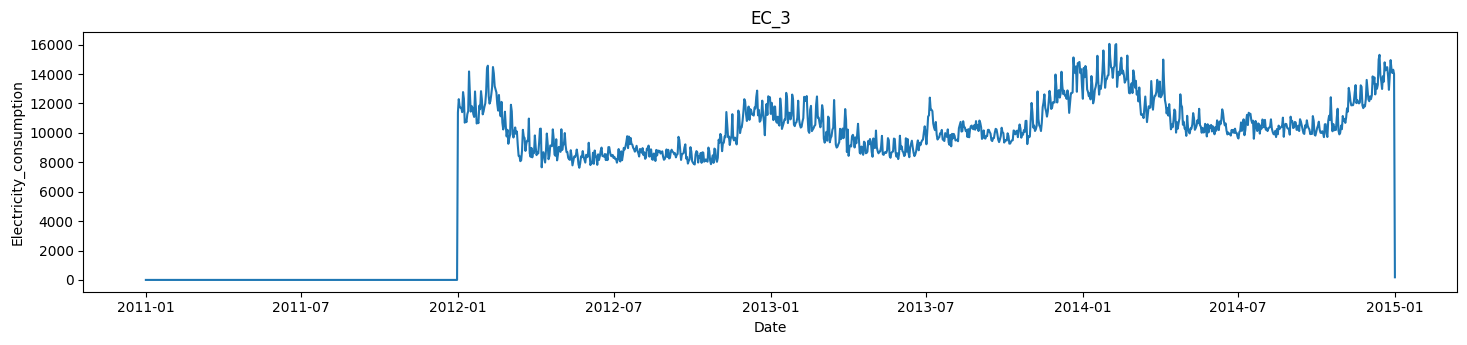

In [ ]:
df_ini = open_data(columns=["EC_3"])
df_ini = aggregate_data(df_ini, freq='1D')
df_ini.dropna(inplace=True)
plot_data(df_ini, "EC_3")
df = df_ini.copy()

# Prediction with Fb Prophet

## 1st basic model

In [ ]:
predictor = Prophet()
df.reset_index(inplace=True) # necessary for prophet
df.columns = ['ds', 'y']    # necessary for prophet: it only works with these names
print(df.head())
print(df.tail())

          ds    y
0 2011-01-01  0.0
1 2011-01-02  0.0
2 2011-01-03  0.0
3 2011-01-04  0.0
4 2011-01-05  0.0
             ds             y
1457 2014-12-28  14327.235772
1458 2014-12-29  14067.073171
1459 2014-12-30  14290.650407
1460 2014-12-31  14006.097561
1461 2015-01-01    178.861789


In [ ]:
predictor.fit(df)

In [ ]:
future = predictor.make_future_dataframe(periods=365, freq='D', include_history=False)
forecast = predictor.predict(future)
print(forecast.head())
print(forecast.tail())

          ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2015-01-02  12150.968130  12432.166732  15795.479917  12150.968130   
1 2015-01-03  12153.139510  13148.925382  16441.223231  12153.139510   
2 2015-01-04  12155.310891  12911.714757  16297.486857  12155.310891   
3 2015-01-05  12157.482271  12640.005707  15892.603950  12157.482271   
4 2015-01-06  12159.653652  12920.409290  16042.374588  12159.653652   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  12150.968130     1898.516235           1898.516235           1898.516235   
1  12153.139510     2656.041414           2656.041414           2656.041414   
2  12155.310891     2447.766915           2447.766915           2447.766915   
3  12157.482271     2209.423443           2209.423443           2209.423443   
4  12159.653652     2320.303873           2320.303873           2320.303873   

       weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
0  -57.166151    -57

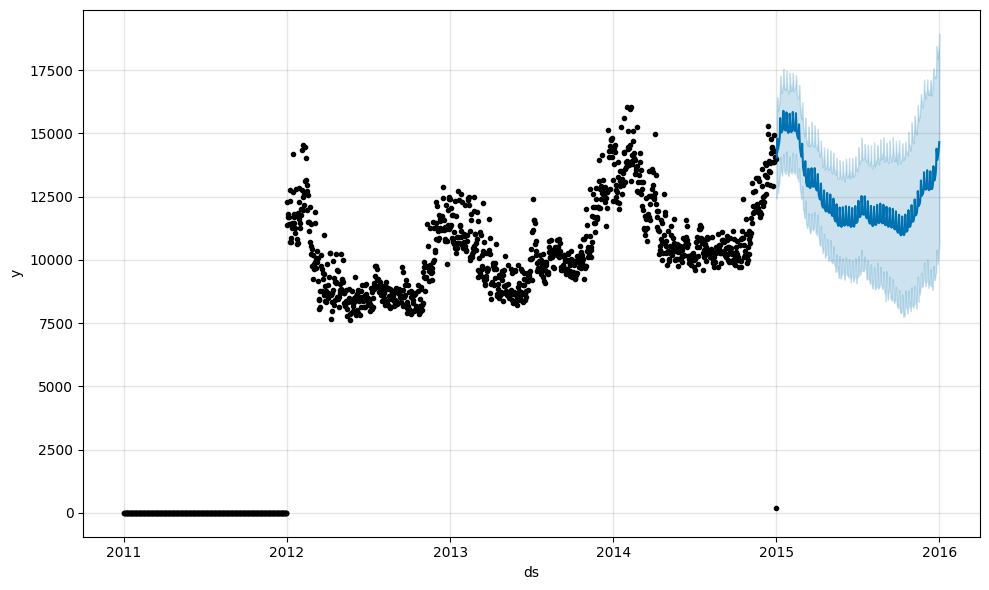

In [ ]:
fig = predictor.plot(forecast)

## Rigorous approach to time series forecasting

We are going to use the following steps:
1. Split the data into train and test sets
2. Define the model
3. Fit the model to the training data
4. Make an out-of-sample forecast
5. Evaluate forecast accuracy
6. Plot the forecast

In [ ]:
test_size = 31
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]
# remove the last row from the test set

In [ ]:
predictor = Prophet()
predictor.fit(train_df)

16:37:12 - cmdstanpy - INFO - Chain [1] start processing
16:37:14 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = predictor.make_future_dataframe(periods=test_size, freq='D', include_history=False)
forecast = predictor.predict(future)


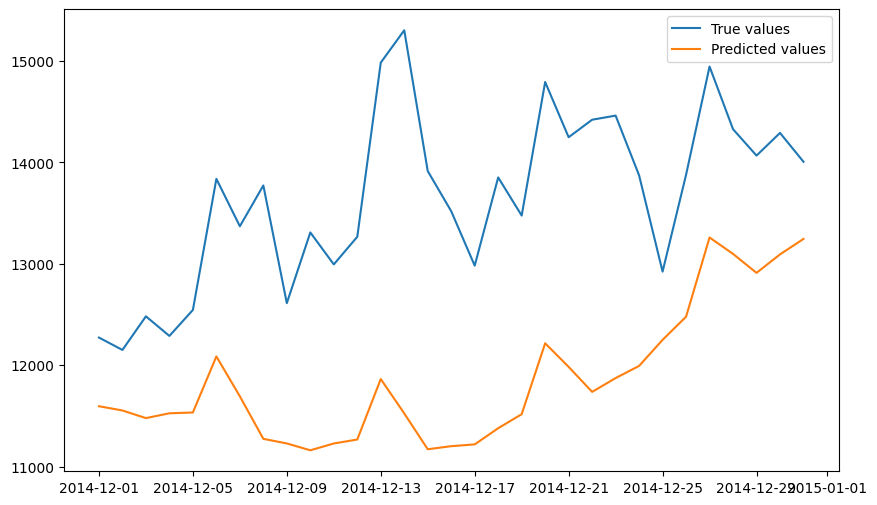

MAPE: 12.93%


In [ ]:
# Plot the true value VS the predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='True values')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted values')
plt.legend()
plt.show()

# Calculate the MAPE
mape = calculate_mape(test_df['y'], forecast['yhat'])
print(f"MAPE: {mape:.2%}")

## Different approach
We keep the whole data (we don't aggregate it, to see if training 15min per 15min can help)

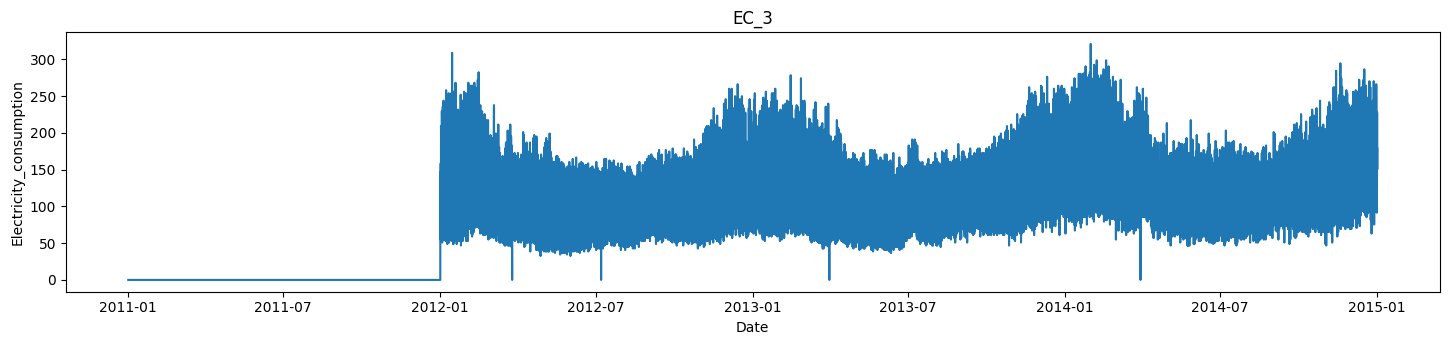

In [ ]:
df_ini = open_data(columns=["EC_3"])
#df_ini = aggregate_data(df_ini, freq='1D')
df_ini.dropna(inplace=True)
plot_data(df_ini, "EC_3")
df = df_ini.copy()

In [ ]:
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
test_size = 31*4*24
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]
# remove the last row from the test set

In [ ]:
predictor = Prophet()
predictor.fit(train_df)

19:13:12 - cmdstanpy - INFO - Chain [1] start processing
19:15:22 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = test_df[['ds']]
future.head()

,ds
137279,2014-12-01 00:00:00
137280,2014-12-01 00:15:00
137281,2014-12-01 00:30:00
137282,2014-12-01 00:45:00
137283,2014-12-01 01:00:00


In [ ]:
forecast = predictor.predict(future)

In [ ]:
print(forecast.head())

                   ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2014-12-01 00:00:00  133.810391  110.944053  170.073524   133.810391   
1 2014-12-01 00:15:00  133.811322  109.413974  166.945508   133.811322   
2 2014-12-01 00:30:00  133.812252  103.404331  161.051294   133.812252   
3 2014-12-01 00:45:00  133.813183  101.242888  159.605804   133.813183   
4 2014-12-01 01:00:00  133.814114   97.990347  154.865189   133.814114   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   133.810391        6.167753              6.167753              6.167753   
1   133.811322        2.491936              2.491936              2.491936   
2   133.812252       -0.914941             -0.914941             -0.914941   
3   133.813183       -4.033455             -4.033455             -4.033455   
4   133.814114       -6.859261             -6.859261             -6.859261   

      daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0  9.728933  ... -

Now we aggregate the data to 1 day, as we want to predict the consumption per day

In [ ]:
daily_forecast = forecast.resample('D', on='ds').sum()
daily_truth = test_df.resample('D', on='ds').sum()

In [ ]:
daily_forecast.reset_index(inplace=True)
daily_truth.reset_index(inplace=True)
print(daily_forecast.head())
print(daily_truth.head())

          ds         trend   yhat_lower    yhat_upper   trend_lower  \
0 2014-12-01  12850.042592  9667.025989  15221.612154  12850.042592   
1 2014-12-02  12858.622158  9784.973438  15348.817343  12858.622158   
2 2014-12-03  12867.201725  9669.968889  15210.268767  12867.201725   
3 2014-12-04  12875.781291  9771.441245  15327.842613  12875.781291   
4 2014-12-05  12884.360858  9792.684400  15377.823199  12884.360858   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  12850.042592     -401.678658           -401.678658           -401.678658   
1  12858.622158     -301.046711           -301.046711           -301.046711   
2  12867.201725     -422.642331           -422.642331           -422.642331   
3  12875.781291     -319.280055           -319.280055           -319.280055   
4  12884.360858     -302.937734           -302.937734           -302.937734   

          daily  ...      weekly  weekly_lower  weekly_upper      yearly  \
0 -7.306475e-10  ... -

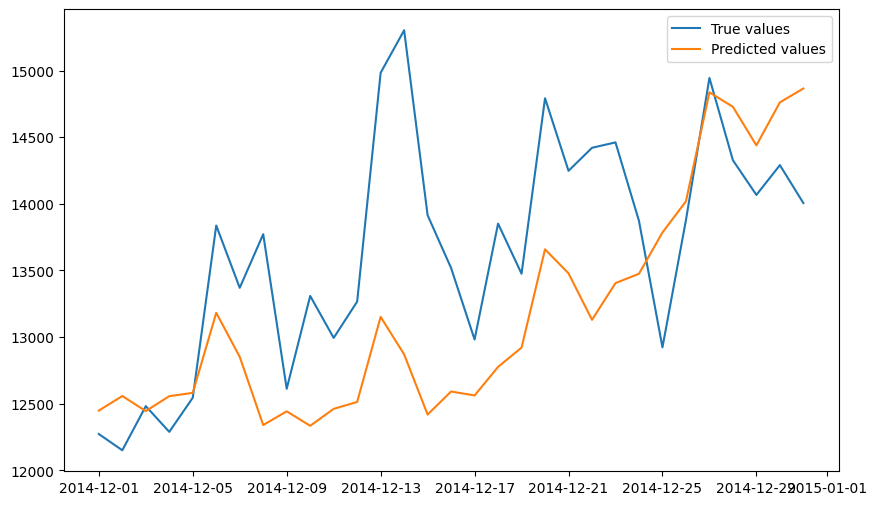

MAPE: 5.20%


In [ ]:
# Plot the true value VS the predicted values
plt.figure(figsize=(10, 6))
plt.plot(daily_truth['ds'], daily_truth['y'], label='True values')
plt.plot(daily_forecast['ds'], daily_forecast['yhat'], label='Predicted values')
plt.legend()
plt.show()

# Calculate the MAPE
mape = calculate_mape(daily_truth['y'], daily_forecast['yhat'])
print(f"MAPE: {mape:.2%}")

## Include holidays
We know that the data comes from Portugal, so we will include the portuguese holidays, to see if it improves the model

In [ ]:
# Holidays are in "Full_holidays.txt"
holidays = pd.read_csv('Data\Full_holidays.txt', sep='\t', header=None)
holidays['holidays'] = 1
holidays.columns = ['ds', 'holiday']
# convert the date column to datetime
holidays['ds'] = pd.to_datetime(holidays['ds'])
print(holidays.head())


          ds  holiday
0 2010-12-20        1
1 2010-12-21        1
2 2010-12-22        1
3 2010-12-23        1
4 2010-12-24        1


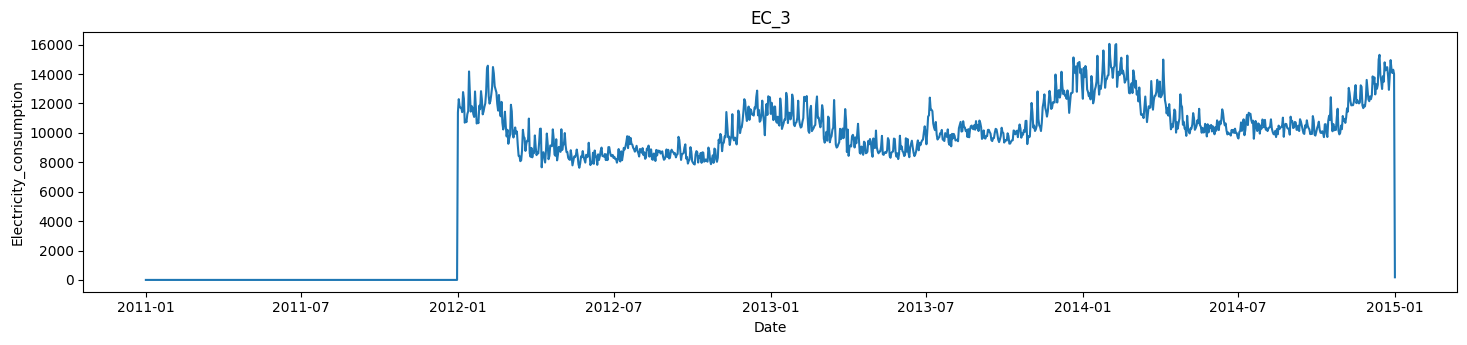

In [ ]:
df_ini = open_data(columns=["EC_3"])
df_ini = aggregate_data(df_ini, freq='1D')
df_ini.dropna(inplace=True)
plot_data(df_ini, "EC_3")
df = df_ini.copy()

In [ ]:
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
test_size = 31
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]

Here is how to proceed to get the data in the right format

In [ ]:
holidays = pd.read_csv('Data\expanded_holidays.txt', sep='\t', header=None)
holidays[1] = 'Portuguese national holiday'
holidays['lower_window'] = 0
holidays['upper_window'] = 1
holidays.rename(columns={0: 'ds', 1: 'holiday'}, inplace=True)
print(holidays.head())

           ds                      holiday  lower_window  upper_window
0  20.12.2010  Portuguese national holiday             0             1
1  21.12.2010  Portuguese national holiday             0             1
2  22.12.2010  Portuguese national holiday             0             1
3  23.12.2010  Portuguese national holiday             0             1
4  24.12.2010  Portuguese national holiday             0             1


In [ ]:
predictor = Prophet(holidays=holidays)
predictor.fit(train_df)

18:45:56 - cmdstanpy - INFO - Chain [1] start processing
18:45:56 - cmdstanpy - INFO - Chain [1] done processing


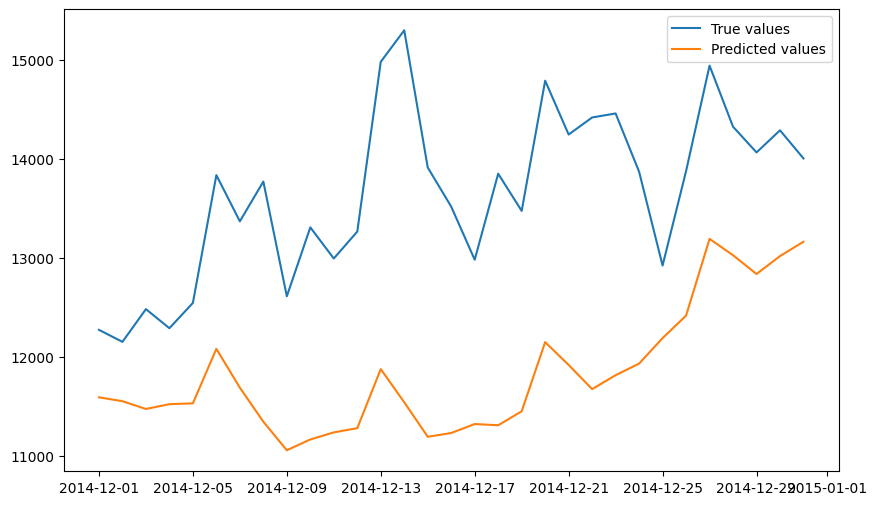

MAPE: 13.14%


In [ ]:
future = predictor.make_future_dataframe(periods=test_size, freq='D', include_history=False)
forecast = predictor.predict(future)

# Plot the true value VS the predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='True values')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted values')
plt.legend()
plt.show()

# Calculate the MAPE
mape = calculate_mape(test_df['y'], forecast['yhat'])
print(f"MAPE: {mape:.2%}")

In [ ]:
forecast[forecast['Portuguese national holiday'] != 0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Portuguese national holiday,Portuguese national holiday_lower,Portuguese national holiday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7,2014-12-08,11710.107989,9916.431671,12803.739952,11710.107989,11710.107989,72.617361,72.617361,72.617361,-367.324233,...,-176.140089,-176.140089,-176.140089,-263.801506,-263.801506,-263.801506,0.0,0.0,0.0,11342.783756
8,2014-12-09,11710.694058,9578.003352,12480.438538,11710.694058,11710.694058,-177.010024,-177.010024,-177.010024,-657.020669,...,-176.335478,-176.335478,-176.335478,-303.675166,-303.675166,-303.675166,0.0,0.0,0.0,11053.673389
16,2014-12-17,11715.382607,9920.965823,12718.286200,11704.451276,11715.468403,72.617361,72.617361,72.617361,-396.061450,...,-211.242652,-211.242652,-211.242652,-257.436159,-257.436159,-257.436159,0.0,0.0,0.0,11319.321157
17,2014-12-18,11715.968676,9788.546657,12750.069658,11703.379793,11718.038895,-104.392663,-104.392663,-104.392663,-409.378446,...,-115.773977,-115.773977,-115.773977,-189.211806,-189.211806,-189.211806,0.0,0.0,0.0,11306.590230
18,2014-12-19,11716.554744,10033.806738,12943.824333,11702.718918,11719.248770,-104.392663,-104.392663,-104.392663,-268.241228,...,-58.382884,-58.382884,-58.382884,-105.465682,-105.465682,-105.465682,0.0,0.0,0.0,11448.313516
19,2014-12-20,11717.140813,10810.450815,13537.296184,11701.385963,11722.355303,-104.392663,-104.392663,-104.392663,430.804805,...,541.656088,541.656088,541.656088,-6.458620,-6.458620,-6.458620,0.0,0.0,0.0,12147.945618
20,2014-12-21,11717.726882,10545.003597,13319.256233,11699.161832,11727.289549,-104.392663,-104.392663,-104.392663,199.083355,...,196.218992,196.218992,196.218992,107.257025,107.257025,107.257025,0.0,0.0,0.0,11916.810236
21,2014-12-22,11718.312950,10229.611930,13123.064325,11696.209546,11731.562461,-104.392663,-104.392663,-104.392663,-45.688671,...,-176.140089,-176.140089,-176.140089,234.844081,234.844081,234.844081,0.0,0.0,0.0,11672.624280
22,2014-12-23,11718.899019,10439.289070,13265.778785,11694.172752,11735.663056,-104.392663,-104.392663,-104.392663,94.465652,...,-176.335478,-176.335478,-176.335478,375.193793,375.193793,375.193793,0.0,0.0,0.0,11813.364671
23,2014-12-24,11719.485088,10562.181785,13260.721716,11690.966270,11739.172807,-104.392663,-104.392663,-104.392663,211.310059,...,-211.242652,-211.242652,-211.242652,526.945374,526.945374,526.945374,0.0,0.0,0.0,11930.795147


## Grid-search for fine tuning

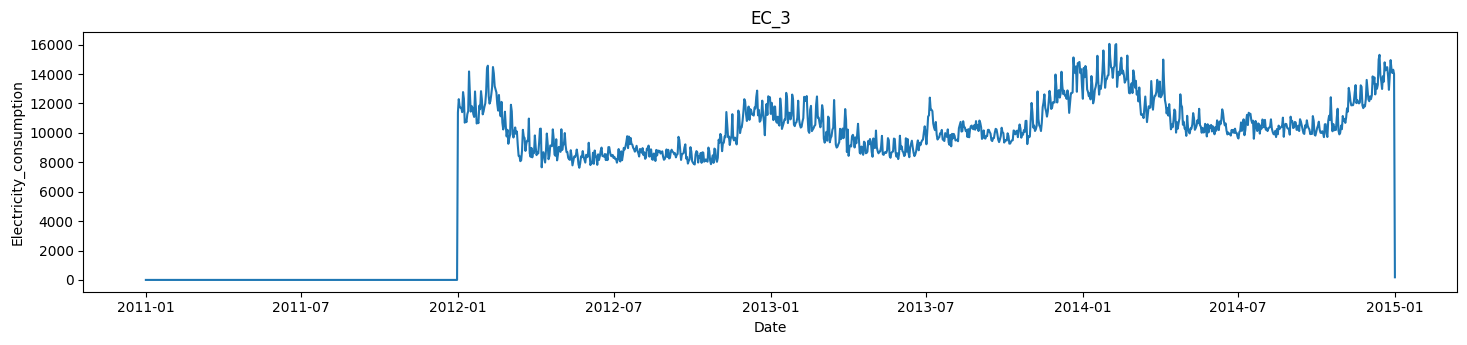

In [ ]:
df_ini = open_data(columns=["EC_3"])
df_ini = aggregate_data(df_ini, freq='1D')
df_ini.dropna(inplace=True)
plot_data(df_ini, "EC_3")
df = df_ini.copy()

In [ ]:
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
test_size = 31
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]

In [ ]:
from sklearn.model_selection import ParameterGrid


# Define the parameter grid for the grid search
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays': [None, holidays],  # 'holidays' should be your holiday dataframe
    'growth': ['linear'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
}

# Initialize the Prophet model
model = Prophet()

results = []

# Perform grid search
for params in ParameterGrid(param_grid):
    model = Prophet(**params)
    model.fit(train_df)

    # Make forecasts
    future = model.make_future_dataframe(periods=test_size, include_history=False)  # Adjust the forecasting window
    forecast = model.predict(future)

    # Calculate MAPE
    true_values = test_df['y']
    predicted_values = forecast['yhat']
    mape = calculate_mape(true_values, predicted_values)

    # Store the results
    results.append({
        'Parameters': params,
        'MAPE': mape,
    })

# Find the best set of parameters based on MAPE
best_result = min(results, key=lambda x: x['MAPE'])
print("Best Parameters:", best_result['Parameters'])
print("Best MAPE:", best_result['MAPE'])


18:50:27 - cmdstanpy - INFO - Chain [1] start processing
18:50:27 - cmdstanpy - INFO - Chain [1] done processing


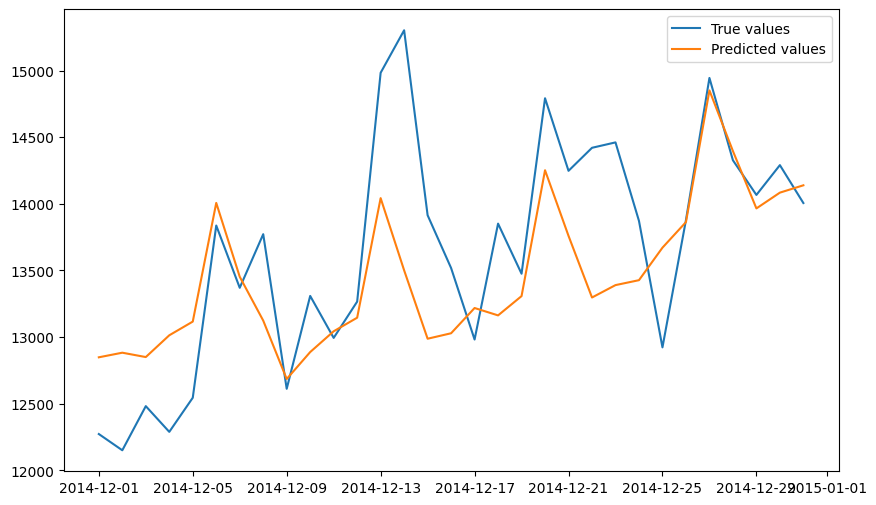

MAPE: 3.4745%


In [ ]:
# Now train the model with the best set of parameters, plot the results, and calculate the MAPE
model = Prophet(**best_result['Parameters'])
model.fit(train_df)

future = model.make_future_dataframe(periods=test_size, include_history=False)
forecast = model.predict(future)

# Plot the true value VS the predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='True values')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted values')
plt.legend()
plt.show()

# Calculate the MAPE
mape = calculate_mape(test_df['y'], forecast['yhat'])
print(f"MAPE: {mape:.4%}")

### Best parameters: {'changepoint_prior_scale': 0.1, 'growth': 'linear', 'holidays': None, 'seasonality_mode': 'multiplicative'}

# Prediction with Fb Prophet for all time series

the goal is to compute the average MAPE for all time series, by training a model for each one of them. (A model cannot be used to predict for sereval time series).

We are going to use the best parameters found in the previous section.

In [ ]:
full_df_ini = open_data()
full_df = full_df_ini.copy()


In [ ]:
holidays = pd.read_csv('Data\expanded_holidays.txt', sep='\t', header=None)
holidays[1] = 'Portuguese national holiday'
holidays['lower_window'] = 0
holidays['upper_window'] = 1
holidays.rename(columns={0: 'ds', 1: 'holiday'}, inplace=True)
print(holidays.head())

           ds                      holiday  lower_window  upper_window
0  20.12.2010  Portuguese national holiday             0             1
1  21.12.2010  Portuguese national holiday             0             1
2  22.12.2010  Portuguese national holiday             0             1
3  23.12.2010  Portuguese national holiday             0             1
4  24.12.2010  Portuguese national holiday             0             1


## Overall fine tuning

In [ ]:
full_df = aggregate_data(full_df, freq='1D')
full_df = keep_important(full_df, 365*1.01)
columns = full_df.columns
print("There are", len(columns), "columns in the dataset")

best_params = {'seasonality_mode': 'multiplicative',
               'holidays': holidays,
               'growth': 'linear',
               'changepoint_prior_scale': 0.05
               }
mape_results = {}
test_size = 31

There are that many column who were removed : 0
[]
There are 318 columns in the dataset


In [ ]:
#Fine tuning over all columns
from sklearn.model_selection import ParameterGrid

# Load and prepare your dataset
# Replace 'your_dataframe' with your actual DataFrame
# Ensure your DataFrame has 'ds' and 'y' columns

# Define the parameter grid for the grid search
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays': [None, holidays],  # 'holidays' should be your holiday dataframe
    'growth': ['linear'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
}

score = {}
for i, parameters in enumerate(ParameterGrid(param_grid)):
    print("Iteration {} - Parameters: {}".format(i, parameters))
    score[i] = 0
    for column in columns:

        df = full_df[[column]].copy()
        df.reset_index(inplace=True)
        df.columns = ['ds', 'y']
        train_df = df[:-test_size-1]
        test_df = df[-test_size-1:-1]

        model = Prophet(**parameters, uncertainty_samples=False)
        model.fit(train_df)

        future = test_df[['ds']]
        forecast = model.predict(future)

        """daily_forecast = forecast.resample('D', on='ds').sum()
        daily_truth = test_df.resample('D', on='ds').sum()

        daily_forecast.reset_index(inplace=True)
        daily_truth.reset_index(inplace=True)"""

        daily_forecast = forecast
        daily_truth = test_df

        daily_forecast.reset_index(inplace=True)
        daily_truth.reset_index(inplace=True)

        # Calculate the MAPE
        mape = calculate_mape(daily_truth['y'], daily_forecast['yhat'])
        mape_results.append(mape)
        if mape != float('inf'):
            score[i]+=mape
        #print("Iteration {} - MAPE: {:.4%}".format(column, mape))


print("Done!")

Total score for each parameter set:

In [ ]:
print(score)

In [ ]:
print(ParameterGrid(param_grid)[7])

{'seasonality_mode': 'multiplicative', 'holidays':             ds                      holiday  lower_window  upper_window
0   2010-12-20  Portuguese national holiday             0             1
1   2010-12-21  Portuguese national holiday             0             1
2   2010-12-22  Portuguese national holiday             0             1
3   2010-12-23  Portuguese national holiday             0             1
4   2010-12-24  Portuguese national holiday             0             1
..         ...                          ...           ...           ...
680 2015-05-01  Portuguese national holiday             0             1
681 2015-06-10  Portuguese national holiday             0             1
682 2015-08-15  Portuguese national holiday             0             1
683 2015-12-08  Portuguese national holiday             0             1
684 2015-12-25  Portuguese national holiday             0             1

[685 rows x 4 columns], 'growth': 'linear', 'changepoint_prior_scale': 0.05}


In [ ]:
{'seasonality_mode': 'multiplicative', 'holidays': holidays, 'growth': 'linear', 'changepoint_prior_scale': 0.05}

In [ ]:
# Iterate over all columns

for column in columns:
    df = full_df[[column]].copy()
    df.reset_index(inplace=True)
    df.columns = ['ds', 'y']
    train_df = df[:-test_size-1]
    test_df = df[-test_size-1:-1]

    model = Prophet(**best_params, uncertainty_samples=False)
    model.fit(train_df)

    future = test_df[['ds']]
    forecast = model.predict(future)

    """daily_forecast = forecast.resample('D', on='ds').sum()
    daily_truth = test_df.resample('D', on='ds').sum()

    daily_forecast.reset_index(inplace=True)
    daily_truth.reset_index(inplace=True)"""

    daily_forecast = forecast
    daily_truth = test_df

    daily_forecast.reset_index(inplace=True)
    daily_truth.reset_index(inplace=True)

    # Calculate the MAPE
    mape = calculate_mape(daily_truth['y'], daily_forecast['yhat'])
    mape_results[column]=mape

    print("Iteration {} - MAPE: {:.4%}".format(column, mape))


print("Done!")

In [ ]:
# remove inf values
print(len(mape_results))
mape_results_clean = {k: v for k,v in mape_results.items() if v != float('inf')}
print(len(mape_results_clean))
print(mape_results)

### Average overall MAPE

In [ ]:
print("Average MAPE: {:.4%}".format(np.mean(list(mape_results_clean.values()))))

Average MAPE: 57.4744%


In [ ]:
mape_results_clean=np.array(mape_results_clean)*100

### MAPE histogram

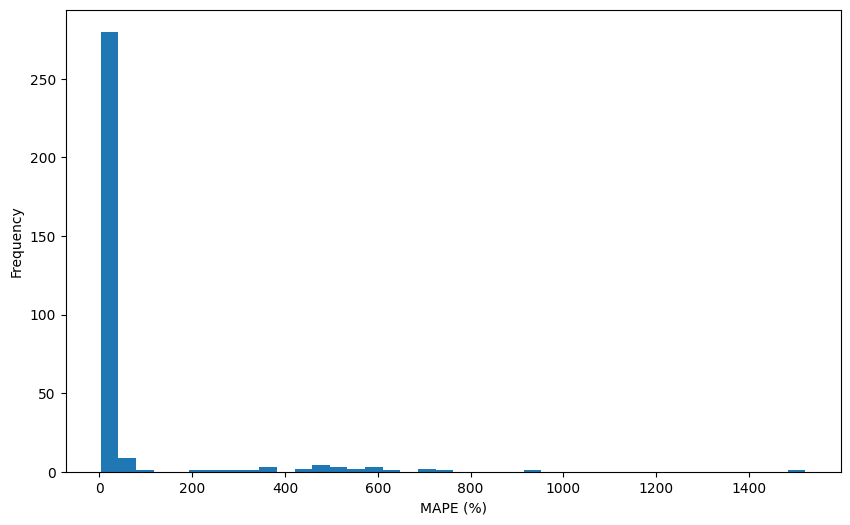

In [ ]:
# plot a histogram of the MAPE results
plt.figure(figsize=(10, 6))
plt.hist(mape_results_clean, bins=40)
plt.xlabel('MAPE (%)')
plt.ylabel('Frequency')
plt.show()

### Analysis of the results: high MAPE vs low MAPE

In [ ]:
high_mapes = {k: v for k,v in mape_results_clean.items() if v > 1}
low_mapes = {k: v for k,v in mape_results_clean.items() if v <= 1}
print(np.mean(list(low_mapes.values())))

0.12249674054040516


In [ ]:
print(high_mapes)

{'EC_2': 5.473703896556939, 'EC_22': 2.6881593187611985, 'EC_56': 5.18163857045811, 'EC_63': 3.1328077441209827, 'EC_89': 2.1720556278000145, 'EC_92': 4.336642888963429, 'EC_122': 3.7534324929356453, 'EC_135': 9.180197671342802, 'EC_142': 7.504817432496499, 'EC_150': 5.498082944409341, 'EC_173': 5.123349170642898, 'EC_174': 6.282497048321514, 'EC_187': 5.06074397187785, 'EC_202': 1.0967114512468572, 'EC_204': 4.748623394540239, 'EC_228': 2.76720727863854, 'EC_235': 4.533423755919472, 'EC_245': 5.8760106889419905, 'EC_266': 6.016791644190387, 'EC_278': 4.5889523213058565, 'EC_281': 3.7078367735609508, 'EC_312': 4.590427670321957, 'EC_332': 6.870564644396602, 'EC_333': 15.212479334400381, 'EC_334': 4.886181800945548, 'EC_335': 6.99835188260977, 'EC_337': 5.815063023391987, 'EC_345': 3.6956777416767643}


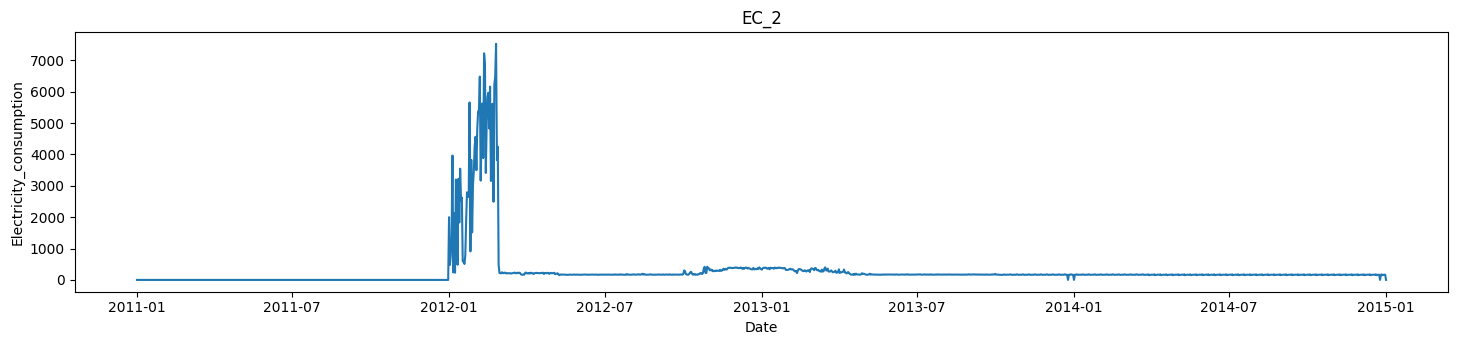

MAPE: 547.3704%


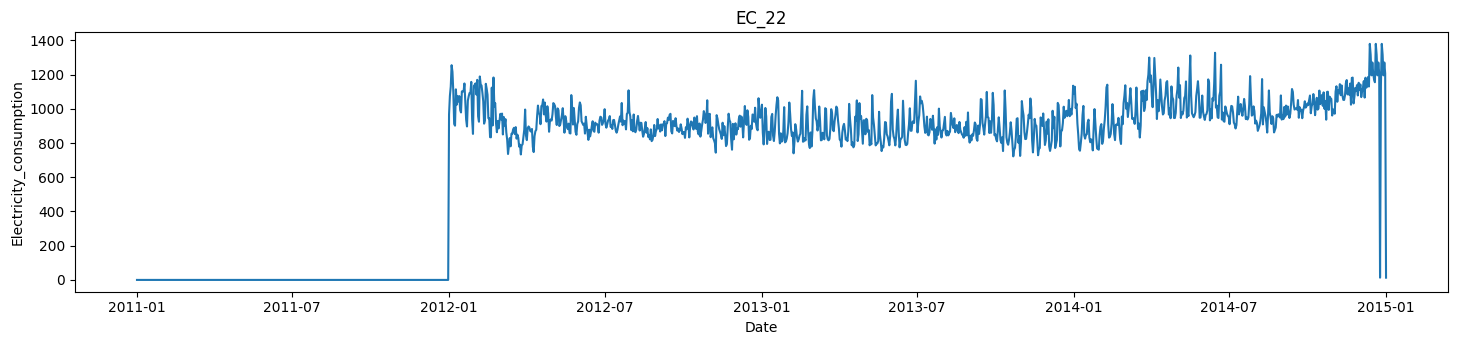

MAPE: 268.8159%


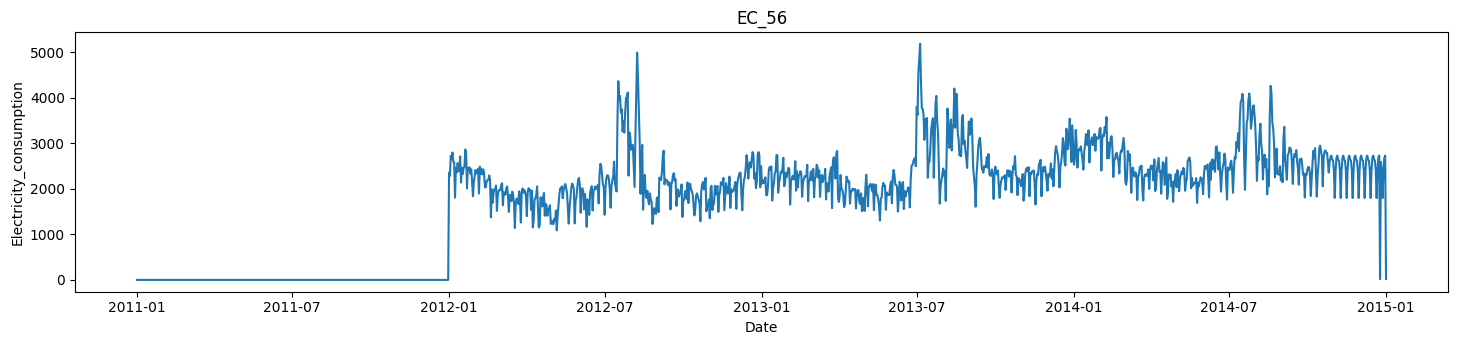

MAPE: 518.1639%


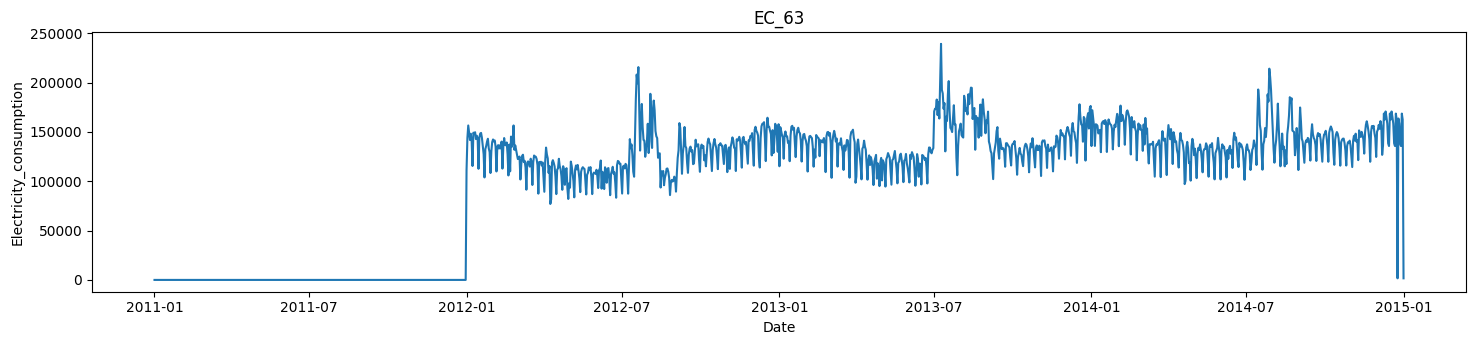

MAPE: 313.2808%


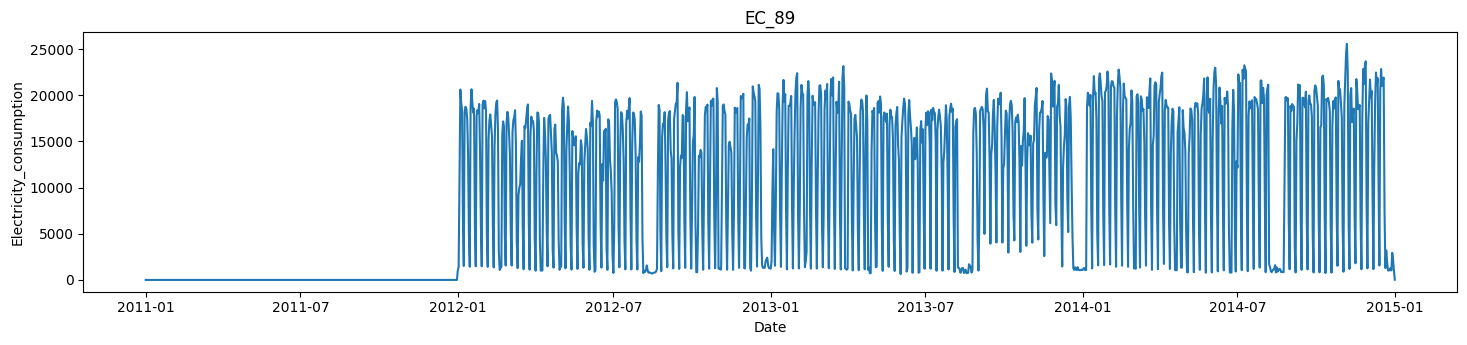

MAPE: 217.2056%


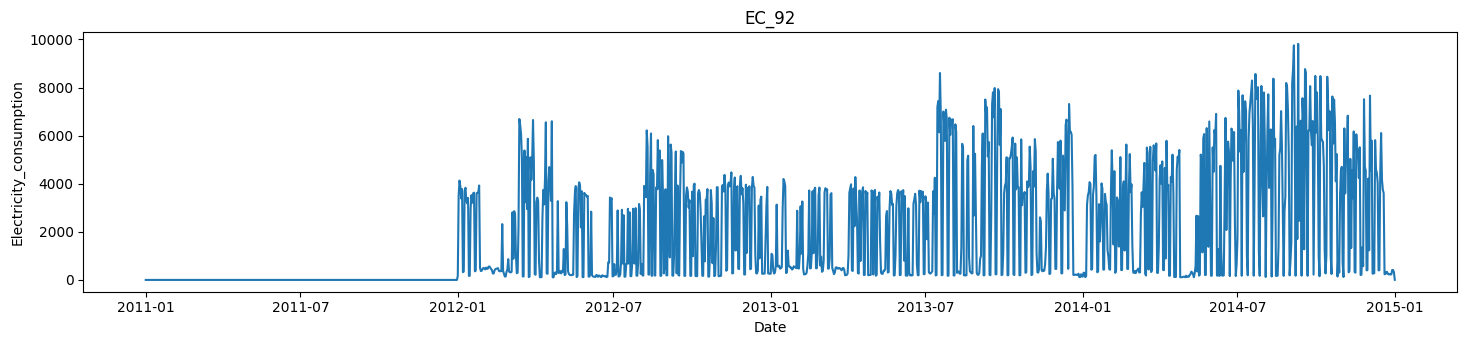

MAPE: 433.6643%


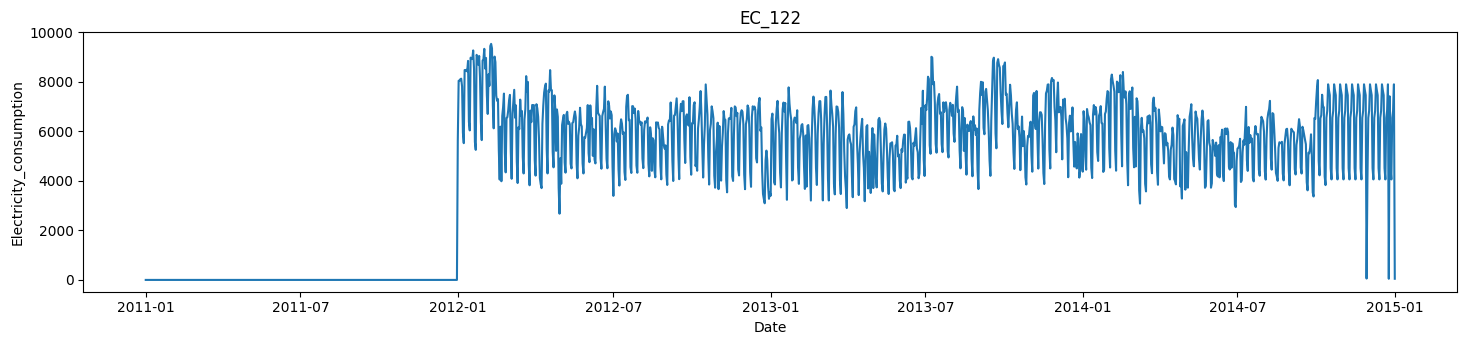

MAPE: 375.3432%


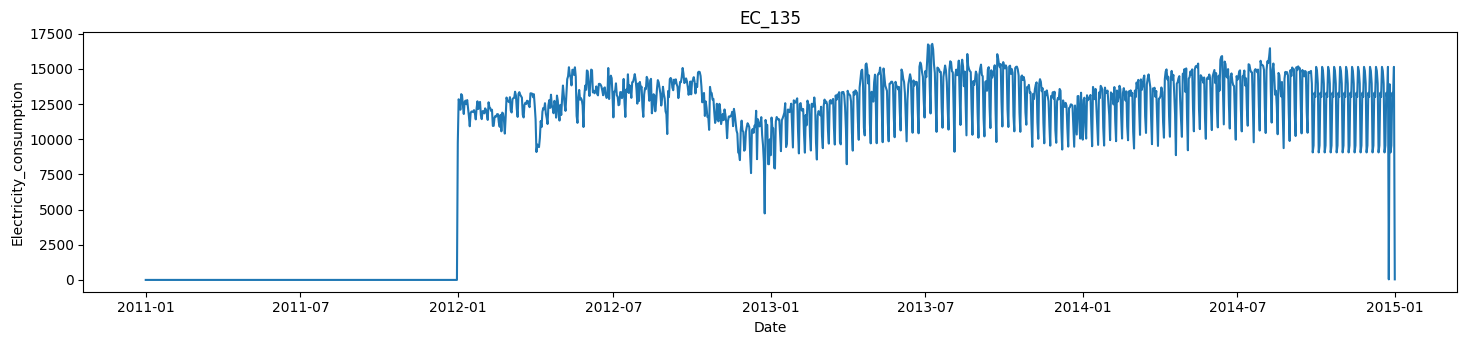

MAPE: 918.0198%


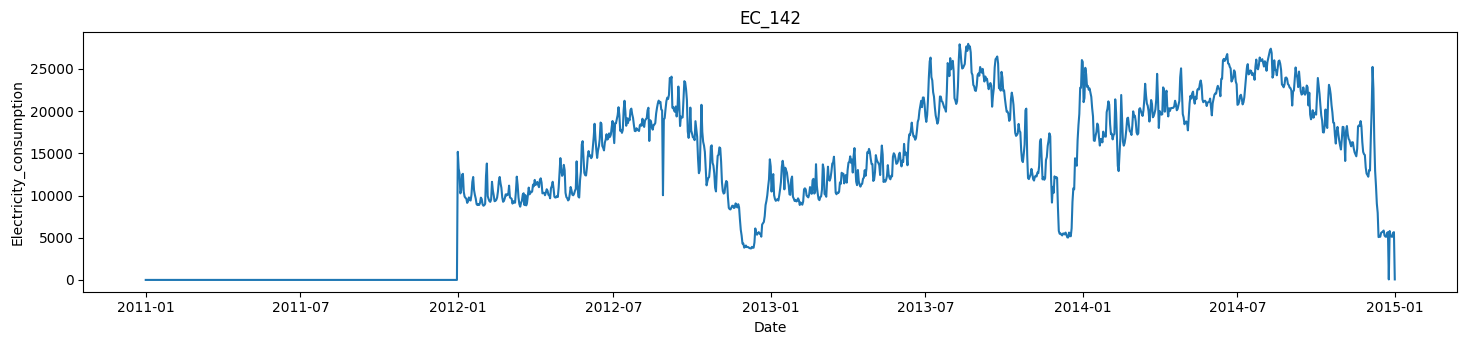

MAPE: 750.4817%


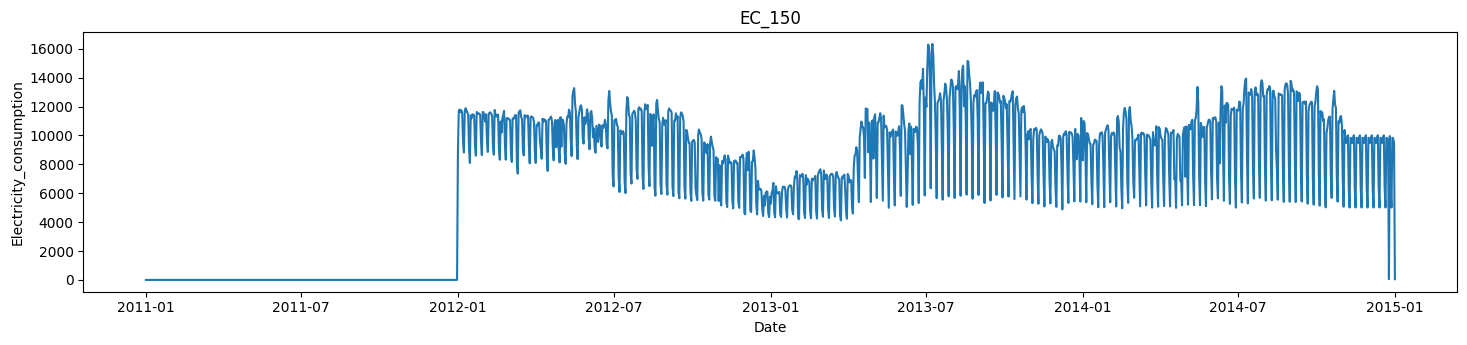

MAPE: 549.8083%


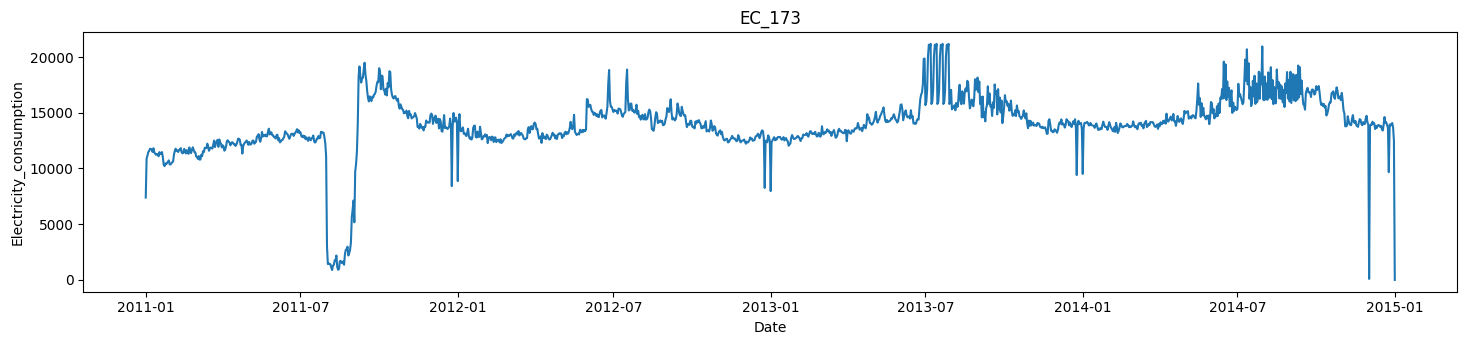

MAPE: 512.3349%


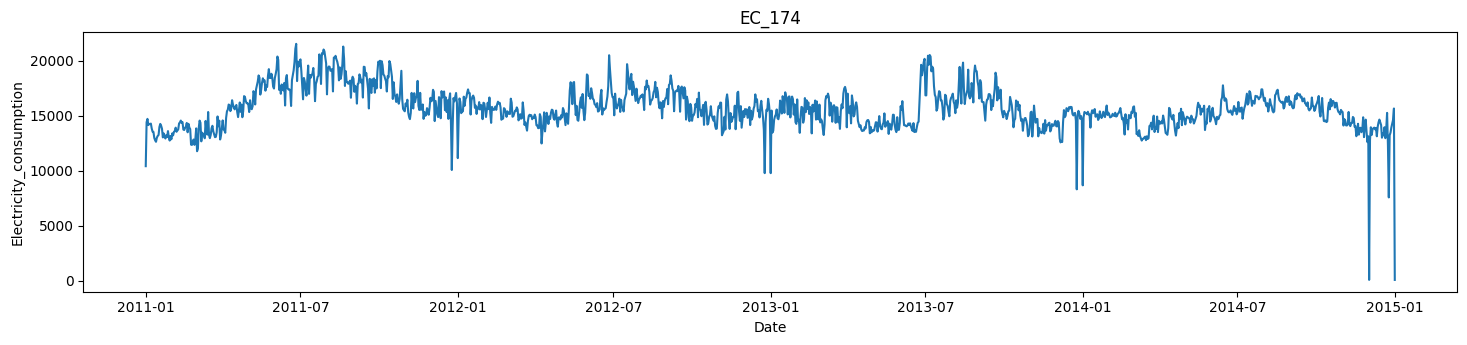

MAPE: 628.2497%


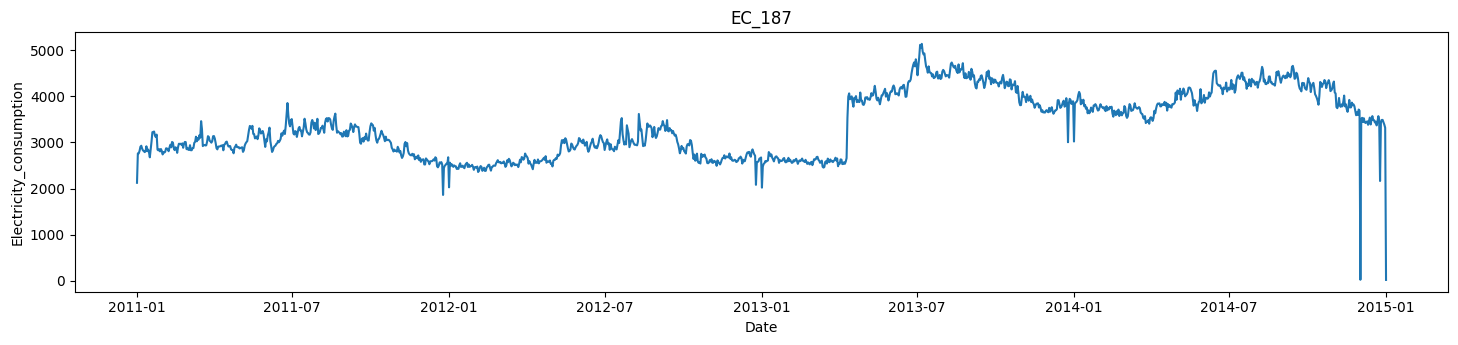

MAPE: 506.0744%


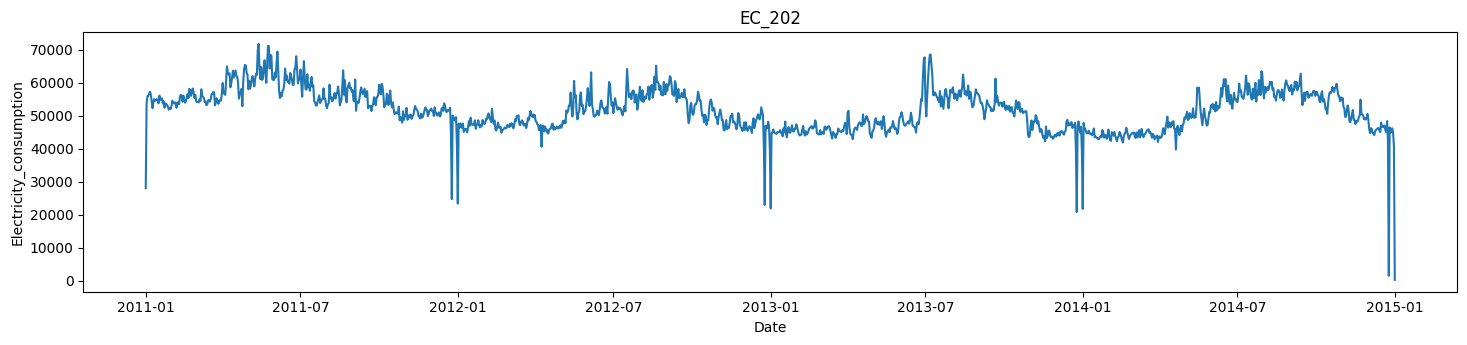

MAPE: 109.6711%


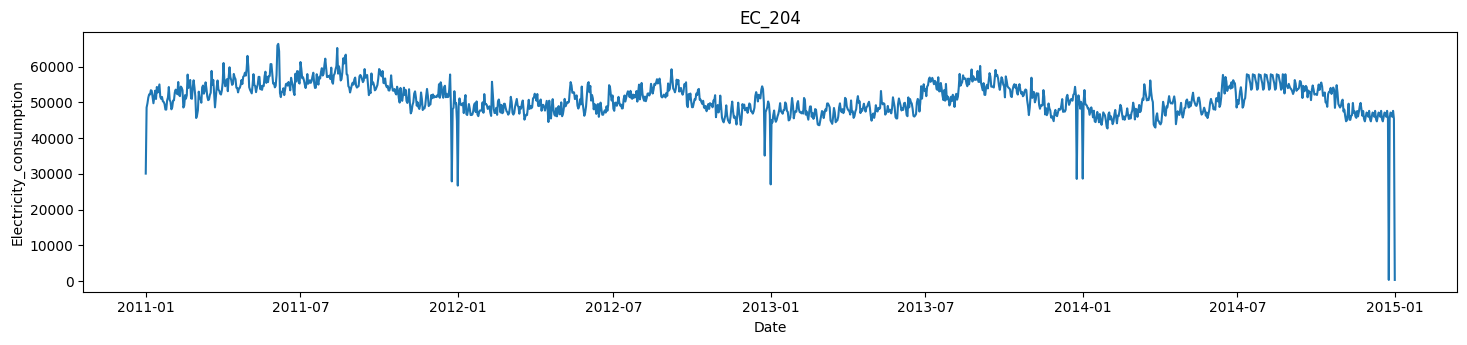

MAPE: 474.8623%


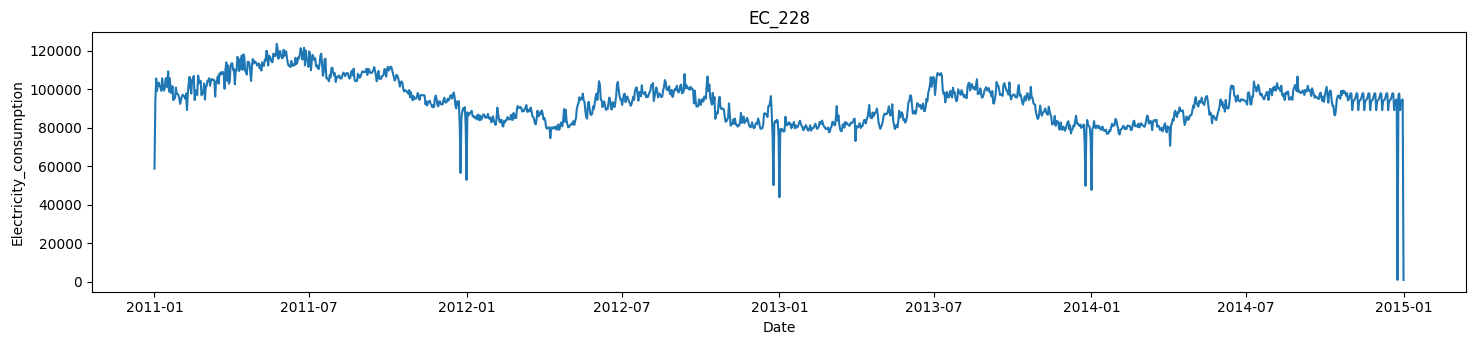

MAPE: 276.7207%


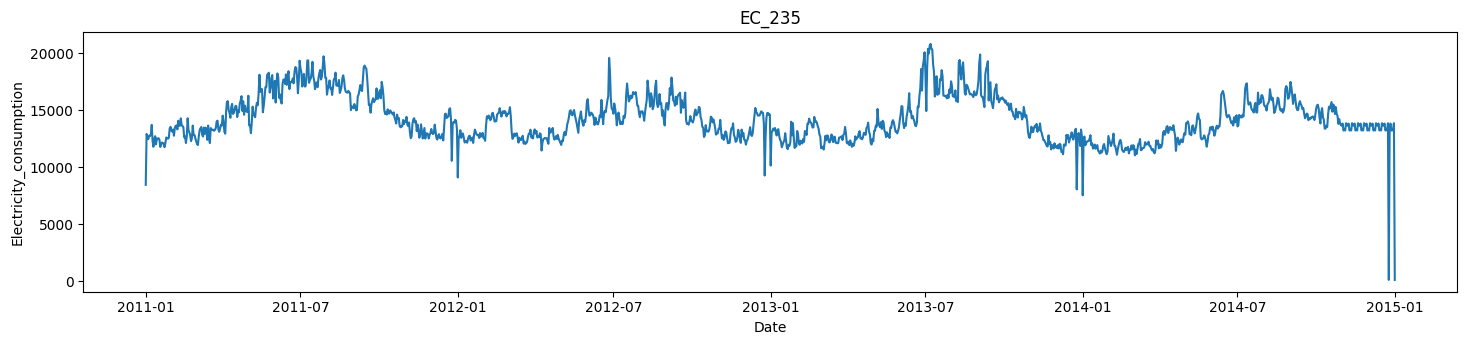

MAPE: 453.3424%


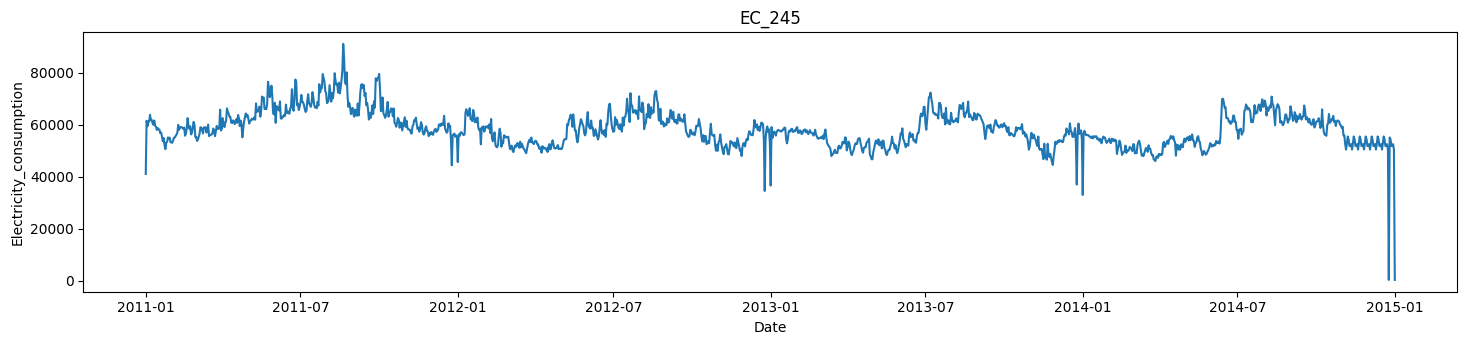

MAPE: 587.6011%


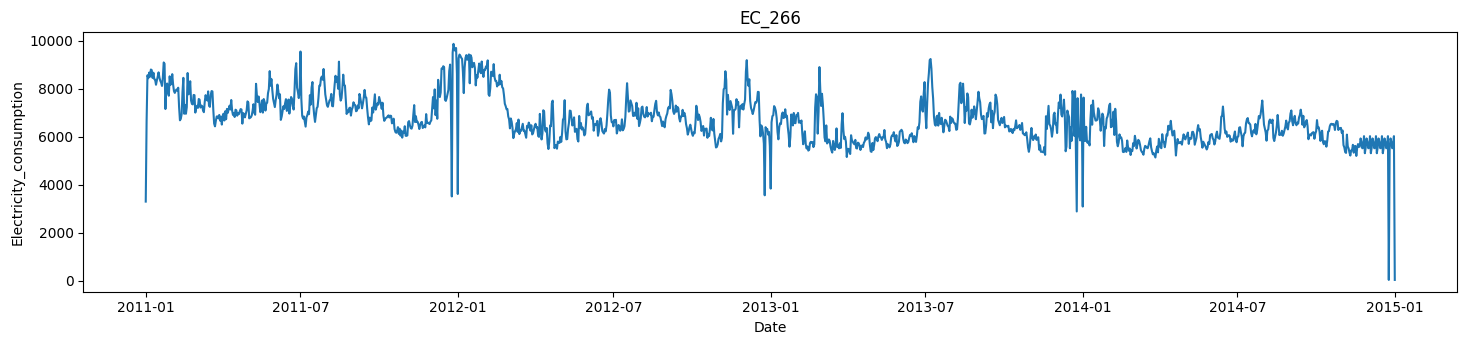

MAPE: 601.6792%


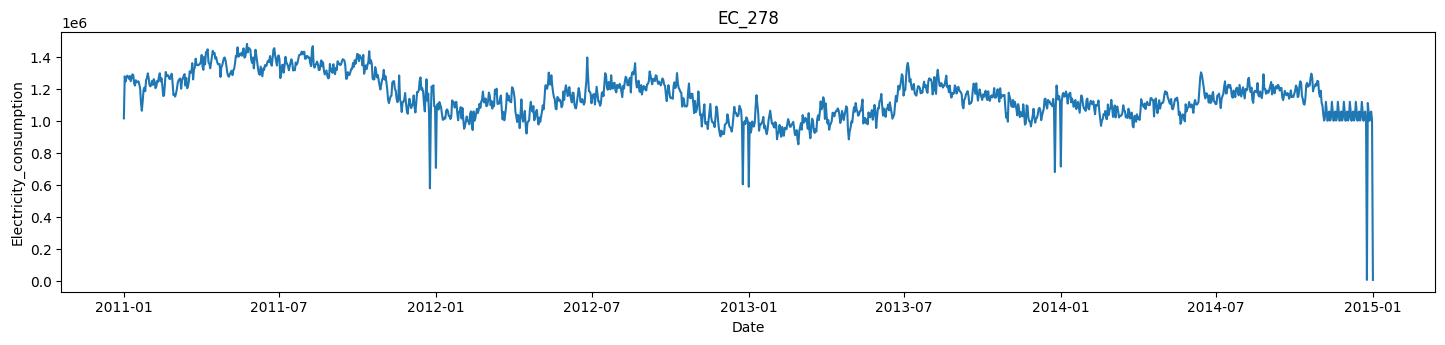

MAPE: 458.8952%


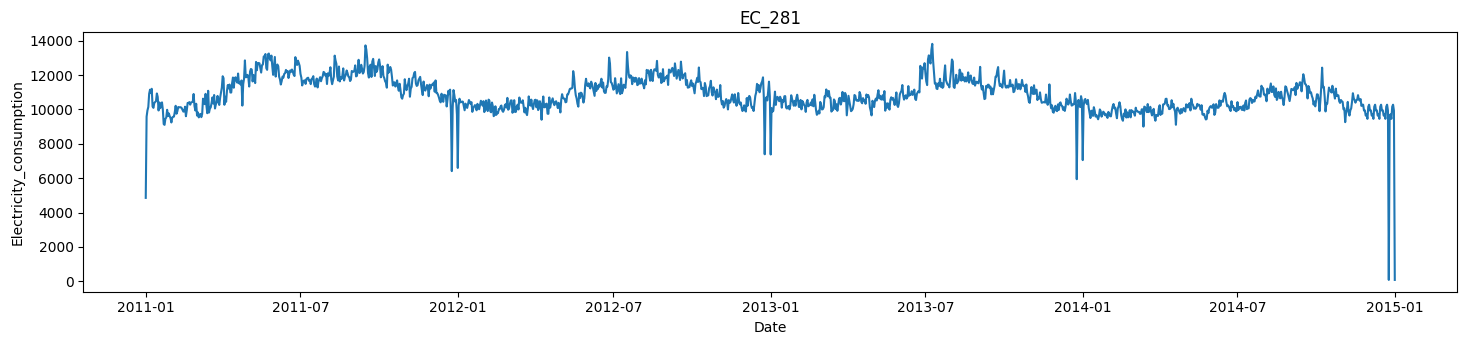

MAPE: 370.7837%


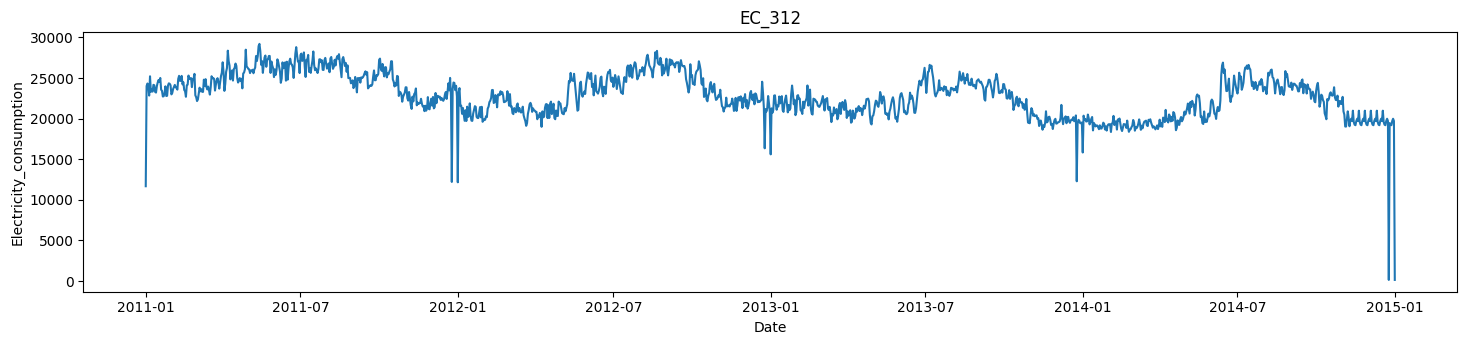

MAPE: 459.0428%


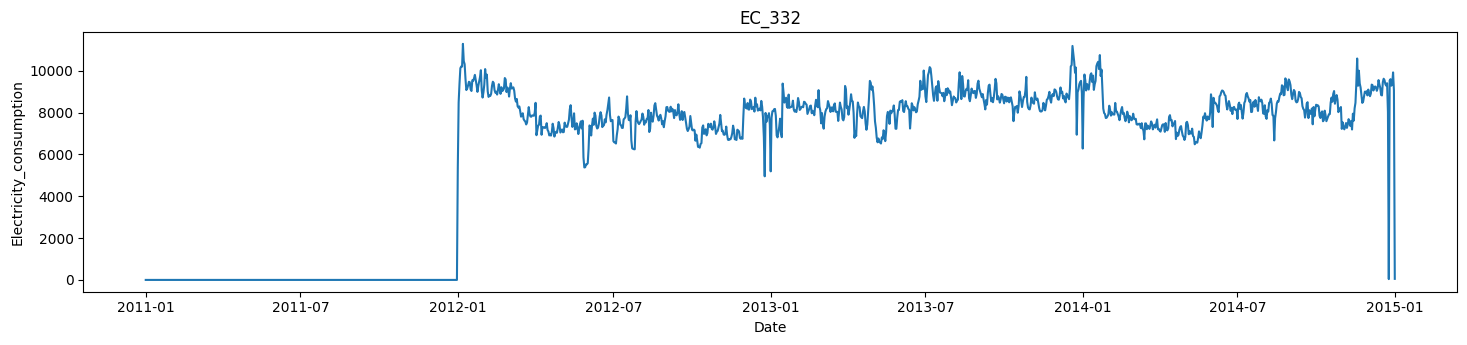

MAPE: 687.0565%


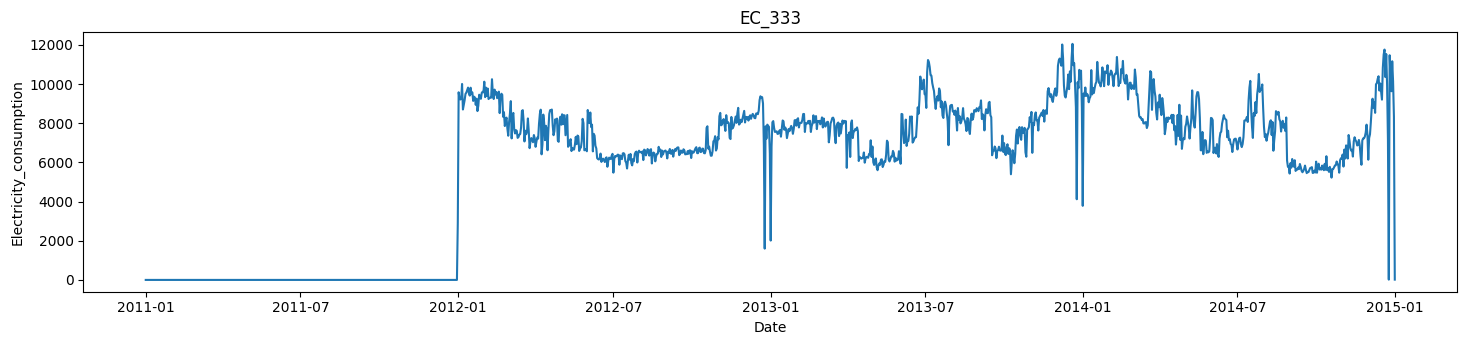

MAPE: 1521.2479%


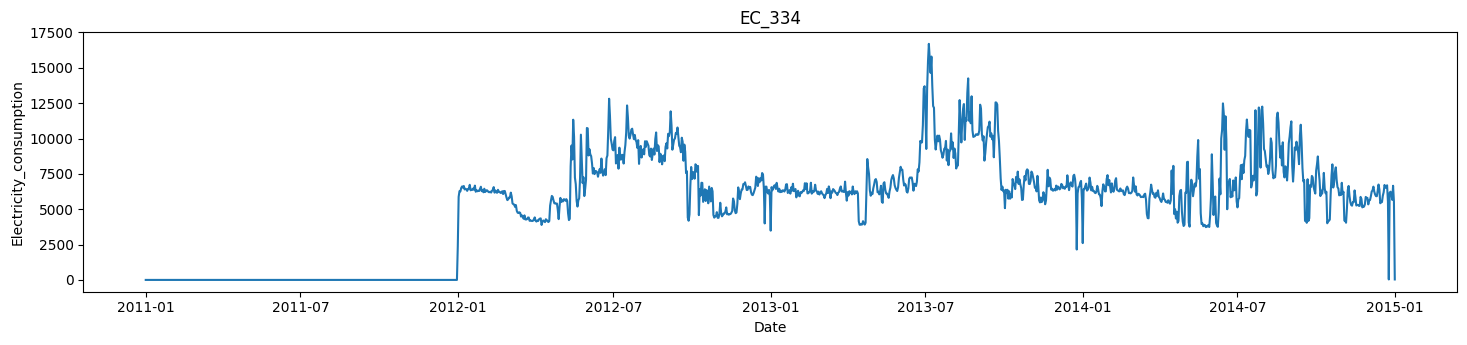

MAPE: 488.6182%


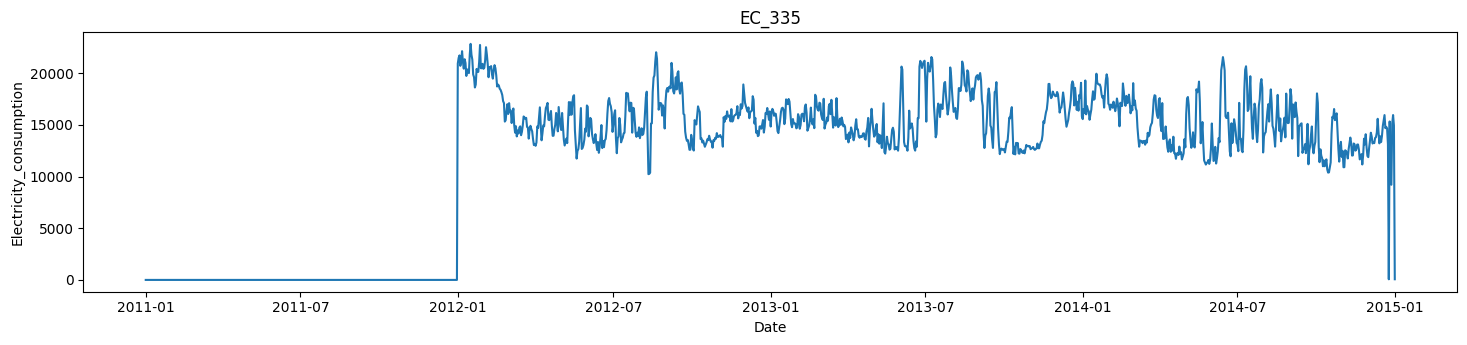

MAPE: 699.8352%


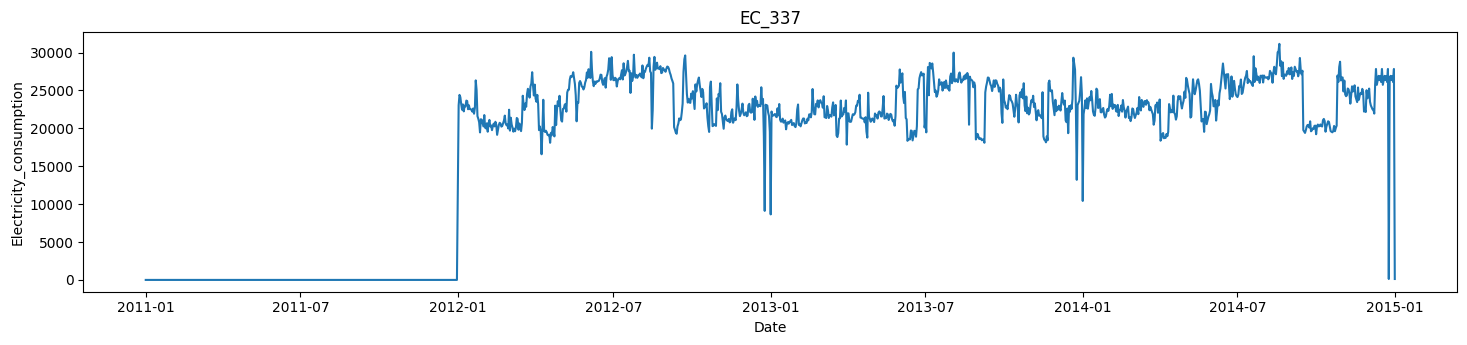

MAPE: 581.5063%


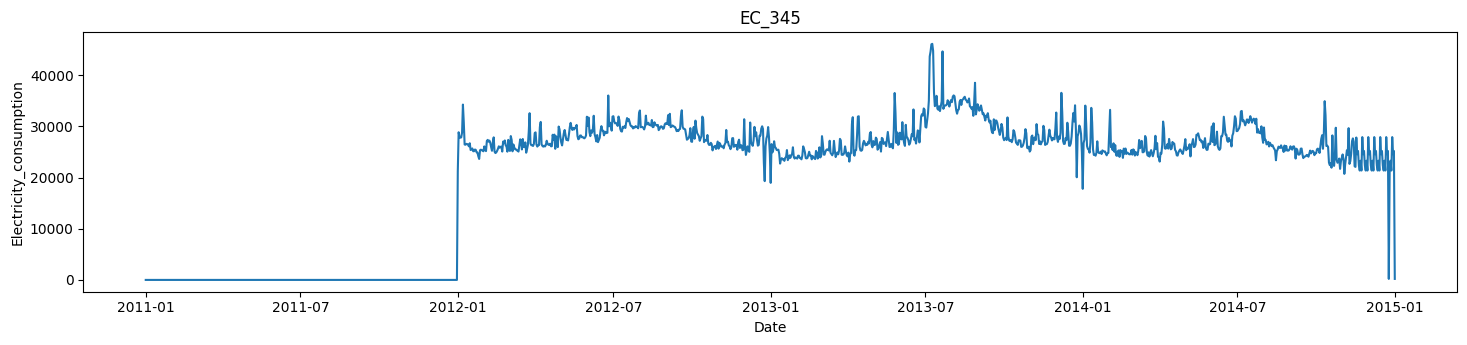

MAPE: 369.5678%


In [ ]:
# plot the time series with a mape greater than 60%

for i in high_mapes.keys():
    plot_data(full_df, i)
    print("MAPE: {:.4%}".format(high_mapes[i]))

### Plotting the predictons for the best and worst time series

In [ ]:
best_pred = float('inf')
for k in low_mapes.keys():
    if low_mapes[k] < best_pred:
        best_pred = low_mapes[k]
        best_index = k

print(best_index)

EC_160


19:55:38 - cmdstanpy - INFO - Chain [1] start processing
19:55:39 - cmdstanpy - INFO - Chain [1] done processing


The MAPE is 3.3495%


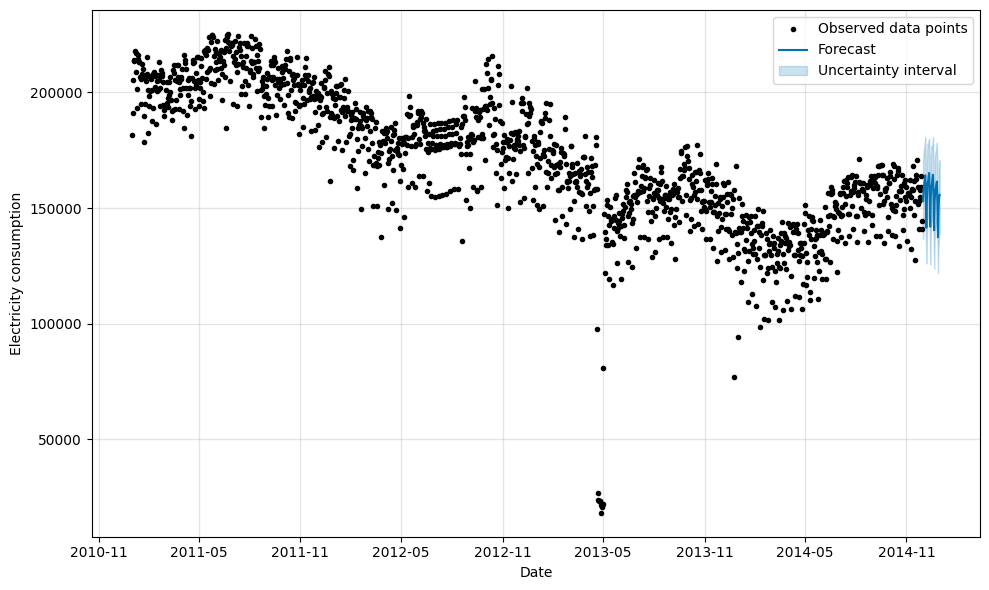

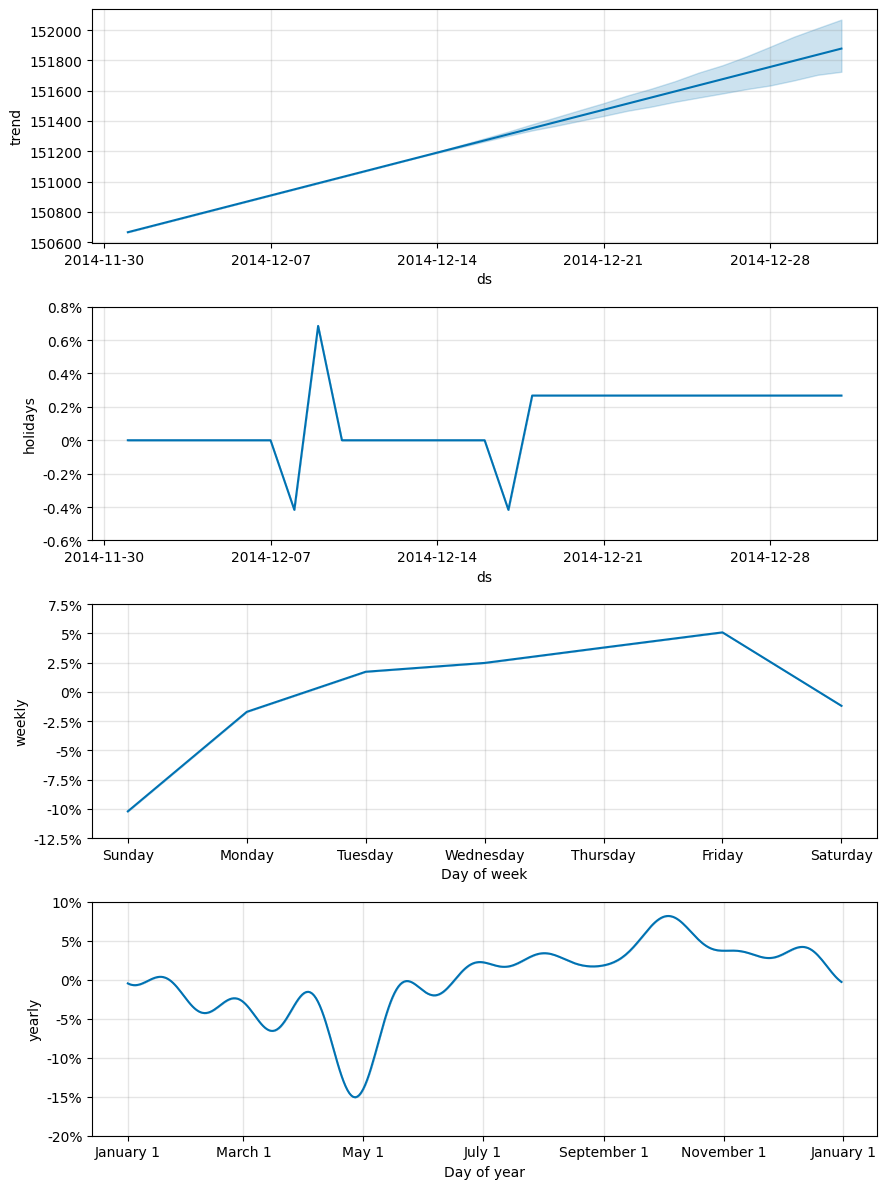

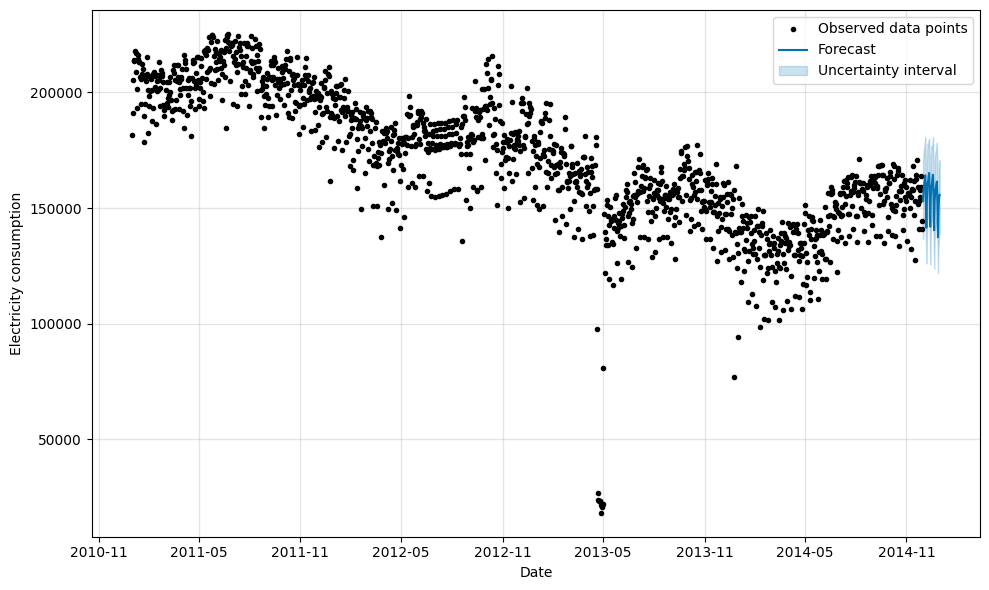

In [ ]:
best_col = best_index # EC_160

df = full_df[[best_col]].copy()
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]

model = Prophet(**best_params)
model.fit(train_df)

future = test_df[['ds']]
forecast = model.predict(future)

print("The MAPE is {:.4%}".format(calculate_mape(test_df['y'], forecast['yhat'])))

model.plot_components(forecast)
model.plot(forecast[-100:], xlabel='Date', ylabel='Electricity consumption', include_legend=True)

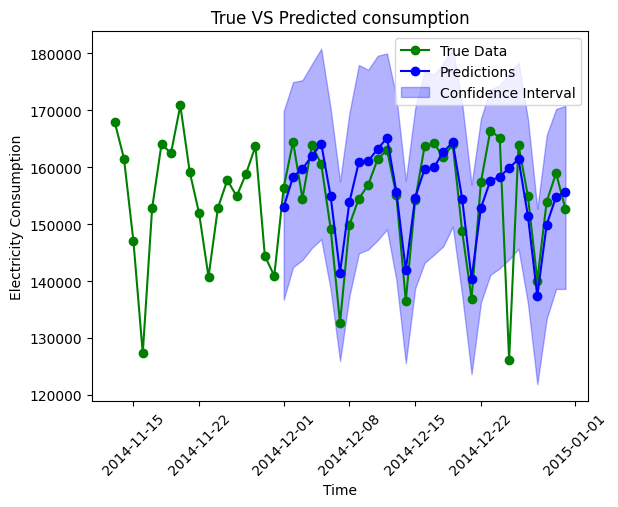

In [ ]:
# Example data (replace with your actual data)
true_data = df['y'][-50:-1]
xtrue_data = df['ds'][-50:-1]
predictions = forecast['yhat'][-100:]
confidence_interval_low = forecast['yhat_lower'][-100:]
confidence_interval_high = forecast['yhat_upper'][-100:]

# Create an array for x-axis (e.g., time or index)
x = test_df['ds'][-100:]

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the true data
ax.plot(xtrue_data, true_data, label='True Data', marker='o', color='green')

# Plot your predictions
ax.plot(x, predictions, label='Predictions', marker='o', color='blue')

# Fill the area between the confidence intervals
ax.fill_between(x, confidence_interval_low, confidence_interval_high, alpha=0.3, color='blue', label='Confidence Interval')

plt.xticks(rotation=45)

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Electricity Consumption')
ax.set_title('True VS Predicted consumption')
ax.legend()

# Show the plot
plt.show()


EC_333


08:48:25 - cmdstanpy - INFO - Chain [1] start processing
08:48:26 - cmdstanpy - INFO - Chain [1] done processing


The MAPE is 1521.2479%


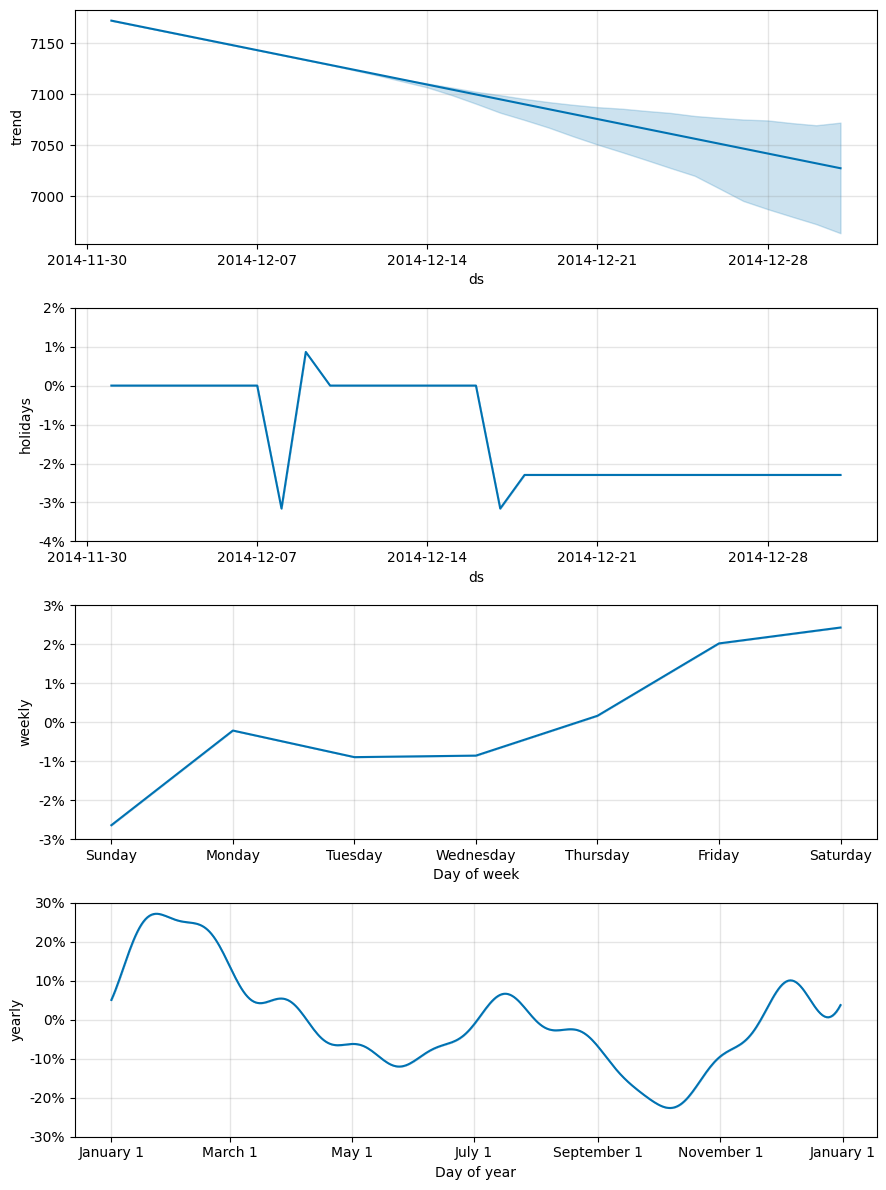

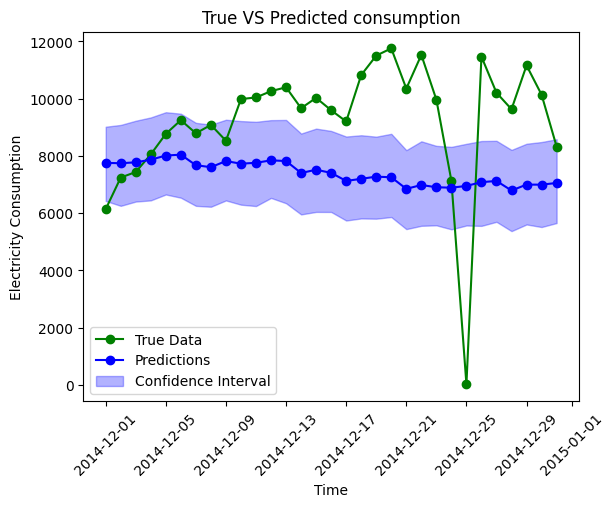

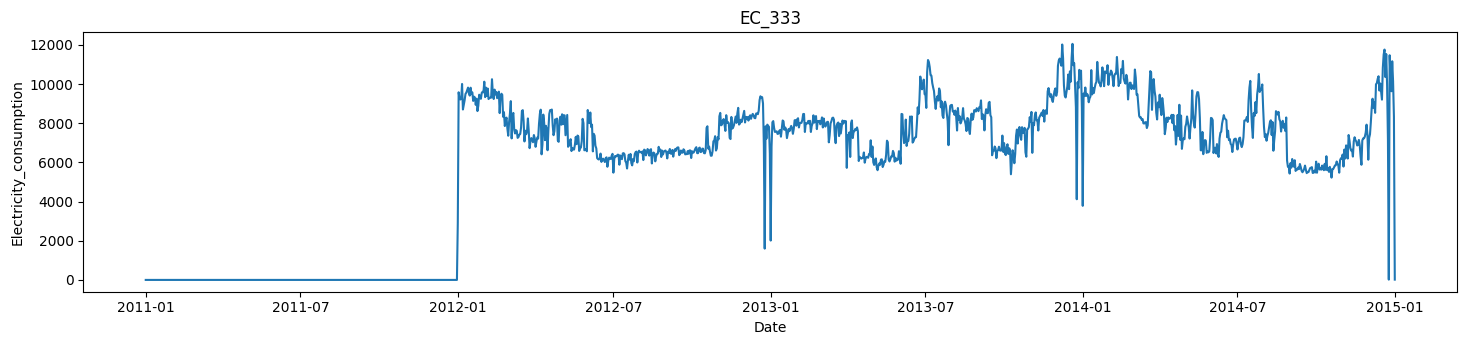

In [ ]:
worse_pred = 0
for k in high_mapes.keys():
    if high_mapes[k] > worse_pred:
        worse_pred = high_mapes[k]
        worse_index = k

print(worse_index)

df = full_df[[worse_index]].copy()
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]

model = Prophet(**best_params)
model.fit(train_df)

future = test_df[['ds']]
forecast = model.predict(future)

print("The MAPE is {:.4%}".format(calculate_mape(test_df['y'], forecast['yhat'])))
model.plot_components(forecast)

# Example data (replace with your actual data)
true_data = df['y'][-test_size-1:-1]
xtrue_data = df['ds'][-test_size-1:-1]
predictions = forecast['yhat'][-100:]
confidence_interval_low = forecast['yhat_lower'][-100:]
confidence_interval_high = forecast['yhat_upper'][-100:]

# Create an array for x-axis (e.g., time or index)
x = test_df['ds'][-100:]

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the true data
ax.plot(xtrue_data, true_data, label='True Data', marker='o', color='green')

# Plot your predictions
ax.plot(x, predictions, label='Predictions', marker='o', color='blue')

# Fill the area between the confidence intervals
ax.fill_between(x, confidence_interval_low, confidence_interval_high, alpha=0.3, color='blue', label='Confidence Interval')

plt.xticks(rotation=45)

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Electricity Consumption')
ax.set_title('True VS Predicted consumption')
ax.legend()

# Show the plot
plt.show()

plot_data(full_df, worse_index)